# LSTM Model to generate captions for images


**Contributors**

1. Kartikay Gupta
2. Jash Mitesh Dalal
3. Chaitali Agarwal
4. Rahul Hemal Shah

**Notes**

This notebook was part of CS 685 Project and was run on Unity

In [ ]:
from pycocotools.coco import COCO
import os
import urllib
import zipfile

In [ ]:
def unzipping(zip_file_name, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

In [ ]:
# create COCOAPI folder
os.makedirs('opt', exist_ok=True)

In [ ]:
# move to opt
os.chdir('opt')
!pwd

/work/pi_pgrabowicz_umass_edu/jdalal/nlp/opt


In [ ]:
# clone COCOAPI repo
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 23.87 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [ ]:
# move to /cocoapi
os.chdir('cocoapi')
!pwd

/work/pi_pgrabowicz_umass_edu/jdalal/nlp/opt/cocoapi


In [ ]:
# make sure we're in the cocoapi folder
!pwd

/work/pi_pgrabowicz_umass_edu/jdalal/nlp/opt/cocoapi


In [ ]:
# download annotation data for training and validation dataset (ver: 2014)
urllib.request.urlretrieve(url='http://images.cocodataset.org/annotations/annotations_trainval2014.zip', filename='annotations_trainval2014.zip')

('annotations_trainval2014.zip', <http.client.HTTPMessage at 0x7fad330b4990>)

In [ ]:
# unzip into the same folder (cocoapi)
unzipping('annotations_trainval2014.zip', 'cocoapi')

In [ ]:
# make sure we're insode the cocoapi folder
!pwd

/work/pi_pgrabowicz_umass_edu/jdalal/nlp/opt/cocoapi


In [ ]:
# download testing image info (ver: 2014)
urllib.request.urlretrieve(url='http://images.cocodataset.org/annotations/image_info_test2014.zip', filename='image_info_test2014.zip')

('image_info_test2014.zip', <http.client.HTTPMessage at 0x7fad329e7150>)

In [ ]:
# unzip into the same folder (cocoapi)
unzipping('image_info_test2014.zip', 'cocoapi')

In [ ]:
# make sure we're in the cocoapi folder
!pwd

/work/pi_pgrabowicz_umass_edu/jdalal/nlp/opt/cocoapi


In [ ]:
# download training, validation, and testing images
urllib.request.urlretrieve(url='http://images.cocodataset.org/zips/train2014.zip', filename='train2014.zip')
urllib.request.urlretrieve(url='http://images.cocodataset.org/zips/val2014.zip', filename='val2014.zip')
urllib.request.urlretrieve(url='http://images.cocodataset.org/zips/test2014.zip', filename='test2014.zip')

('test2014.zip', <http.client.HTTPMessage at 0x7fad329dd710>)

In [ ]:
# unzip images
unzipping('train2014.zip', 'cocoapi')
unzipping('val2014.zip', 'cocoapi')
unzipping('test2014.zip', 'cocoapi')

In [ ]:
import sys
sys.path.append('/work/pi_pgrabowicz_umass_edu/jdalal/nlp/opt/cocoapi')

In [ ]:
# initialize instance annotation
instance_data_type = 'train'
instance_data_path = 'cocoapi/annotations/instances_{}2014.json'.format(instance_data_type)
coco = COCO(instance_data_path)

loading annotations into memory...
Done (t=13.43s)
creating index...
index created!


In [ ]:
# initialize caption annotations
caption_data_type = 'train'
caption_data_path = 'cocoapi/annotations/captions_{}2014.json'.format(caption_data_type)
coco_caps = COCO(caption_data_path)

loading annotations into memory...
Done (t=1.23s)
creating index...
index created!


In [ ]:
# get image ids
ids = list(coco.anns.keys())
print("Length of ids: {}".format(len(ids)))

Length of ids: 604907


In [ ]:
ids[0]

86

In [ ]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

%matplotlib inline

ann_id = 112430
img_id: 281060
http://images.cocodataset.org/train2014/COCO_train2014_000000281060.jpg


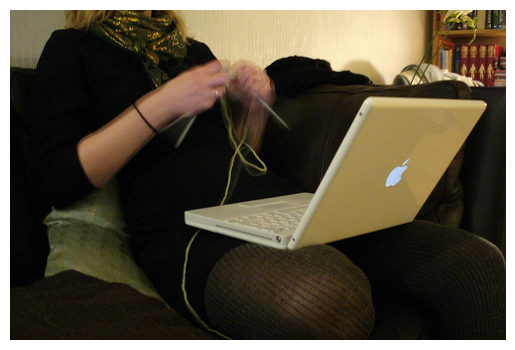

A woman is knitting while she sits with a laptop on her lap.
A woman knitting something with a laptop in her lap.
A woman sitting on her couch knitting while looking at her laptop computer.
A woman sitting on a couch with a laptop on her lap. 
A person with sewing needles sitting down with a laptop in their lap. 


In [ ]:
# random select an index
ann_id = np.random.choice(ids)
print("ann_id = {}".format(ann_id))

# image id
img_id = coco.anns[ann_id]['image_id']
print("img_id: {}".format(img_id))

# image
img = coco.loadImgs(img_id)[0]

# url
url = img['coco_url']
print(url)

# plot
plt.imshow(io.imread(url))
plt.axis('off')
plt.show()

# print all captions
annIds = coco_caps.getAnnIds(imgIds=img_id);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

## Importing Python Libs

In [ ]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler
from torchtext.data.metrics import bleu_score

from PIL import Image
import nltk
nltk.download('punkt')

import sys
sys.path.append("/opt/cocoapi/PythonAPI")

import math
import time
import pickle
import json
import os
import urllib
import zipfile
import random
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

from pycocotools.coco import COCO

# check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/jdalal_umass_edu/.local/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Downloading package punkt to
[nltk_data]     /home/jdalal_umass_edu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


cuda


In [ ]:
import matplotlib.pyplot as plt

## Building Vocab

In [ ]:
class Vocabulary(object):
    def __init__(self, vocab_threshold, vocab_file='/content/vocab.pkl',
                 start_word="<start>", end_word="<end>", unk_word="<unk>",
                 annotations_file="cocoapi/annotations/captions_train2014.json",
                 vocab_from_file=False):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        # load and use the existing vocab file
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')

        # build a new vocab file
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
# minimum count required to add to the vocabulary list
VOCAB_THRESHOLD = 5

# build vocab file from training data
train_vocab = Vocabulary(vocab_threshold=VOCAB_THRESHOLD,
                         vocab_file="./vocab.pkl",
                         start_word="<start>",
                         end_word="<end>",
                         unk_word="<unk>",
                         annotations_file="cocoapi/annotations/captions_train2014.json",
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...


## Training and Validation Data Transformation



In [ ]:
# training data transform
transform_train = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# validation/test data transform
transform_eval = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

### COCO Dataset

In [ ]:
class CoCoDataset_DevMode(torch.utils.data.Dataset):
    def __init__(self, transform, batch_size, vocab_file, annotations_file, img_folder):
        # data transform
        self.transform = transform
        # batch size
        self.batch_size = batch_size
        # vocab
        self.vocab = vocab_file
        # image folder
        self.img_folder = img_folder
        # initialize COCO
        self.coco = COCO(annotations_file)
        # annotation ids
        self.ids = list(self.coco.anns.keys())
        print('Obtaining caption lengths...')
        all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
        self.caption_lengths = [len(token) for token in all_tokens]

    def __getitem__(self, idx):
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
        image = self.transform(image)

        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(self.vocab(self.vocab.start_word))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab(self.vocab.end_word))
        caption = torch.Tensor(caption).long()

        return image, caption

    def get_data_indices(self):
        # choose a length of the caption
        sel_length = np.random.choice(self.caption_lengths)
        # find all availalbe captions with this length
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        # select batch_size captions among them
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        return len(self.ids)

In [ ]:
pwd

'/work/pi_pgrabowicz_umass_edu/jdalal/nlp/opt/cocoapi'

### Create Dataset

In [ ]:
# batch size
BATCH_SIZE = 32

# training dataset for training purposes
dataset_train = CoCoDataset_DevMode(transform=transform_train,  # with augmentation
                                      batch_size=BATCH_SIZE,
                                      vocab_file=train_vocab,
                                      annotations_file="cocoapi/annotations/captions_train2014.json",
                                      img_folder="cocoapi/train2014")

training_batch_sampler = BatchSampler(sampler=SubsetRandomSampler(indices=dataset_train.get_data_indices()),
                                      batch_size=dataset_train.batch_size,
                                      drop_last=False)

dataloader_train = DataLoader(dataset=dataset_train, batch_sampler=training_batch_sampler)


# validation dataset for training purposes
dataset_val = CoCoDataset_DevMode(transform=transform_eval,  # no augmentation
                                  batch_size=BATCH_SIZE,
                                  vocab_file=train_vocab,
                                  annotations_file="cocoapi/annotations/captions_val2014.json",
                                  img_folder="cocoapi/val2014")

val_batch_sampler = BatchSampler(sampler=SubsetRandomSampler(indices=dataset_val.get_data_indices()),
                                 batch_size=dataset_val.batch_size,
                                 drop_last=False)

dataloader_val = DataLoader(dataset=dataset_val, batch_sampler=val_batch_sampler)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:31<00:00, 13224.20it/s]


loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:17<00:00, 11727.53it/s]


In [ ]:
# size of vocab
VOCAB_SIZE = len(dataloader_train.dataset.vocab)
print("VOCAB_SIZE: {}".format(VOCAB_SIZE))

VOCAB_SIZE: 8852


## CNN Encoder

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # load the pre-trained ResNet
        resnet = models.resnet50(pretrained=True)
        # freeze the weights
        for param in resnet.parameters():
            param.requires_grad_(False)
        # grab all CNN layers except the last one
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # embedding layers
        self.embedding = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        # resnet stage
        features = self.resnet(images)
        # flatten to 1 dim
        features = features.view(features.size(0), -1)
        # embedding to final feature
        features = self.embedding(features)
        return features

## RNN Decoder

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
            embed_size: dimension of extracted image semantics features
            hidden_size: dimension of decoder hidden states
            vocab_size: size of vocabulary
            num_layers: number of decoder layers
        """
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # LSTM layer(s)
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        batch_size = features.shape[0]
        embed_size = features.shape[1]
        seq_len = captions.shape[1]
        captions = captions[:, :-1]
        embedded_captions = self.embedding(captions)
        features = torch.unsqueeze(features, dim=1)
        # Concatenate to obtain lstm_input
        lstm_input = torch.cat((features, embedded_captions), dim=1)
        # LSTM layer(s)
        lstm_output, lstm_hidden = self.lstm(lstm_input)
        fc_output = self.fc(lstm_output)
        return fc_output


    def sample(self, inputs, states=None, max_len=20):
        tokens = []
        x = inputs
        for _ in range(max_len):
            # lstm layer
            x, states = self.lstm(x, states)
            x = self.fc(x)
            tok = torch.argmax(x, dim=-1)
            tokens.append(int(tok[0, 0]))
            if tok[0, 0] == 1:
                break
            x = self.embedding(tok)
        return tokens

## Training Function

In [ ]:
def train_model(model_name, enc, dec, num_epochs, criterion, optimizer, device):
    # number of steps per epoch
    train_steps_per_epoch = math.ceil(len(dataloader_train.dataset.caption_lengths)/dataloader_train.batch_sampler.batch_size)
    val_steps_per_epoch = math.ceil(len(dataloader_val.dataset.caption_lengths)/dataloader_val.batch_sampler.batch_size)


    # iterate epoch
    for epoch in range(1, num_epochs+1):

        """
        Training
        """
        print("=== Training ===")

        enc.train()
        dec.train()

        train_total_loss = 0.0
        train_n = 0

        for step_i in range(1, train_steps_per_epoch+1):
            # sample training indices from dataloader_train
            training_indices = dataloader_train.dataset.get_data_indices()
            # batch sampler
            new_sampler = SubsetRandomSampler(indices=training_indices)
            # load
            dataloader_train.batch_sampler.sampler = new_sampler

            # load inputs
            images_t, captions_t = next(iter(dataloader_train))

            images_t = images_t.to(device)
            captions_t = captions_t.to(device)

            # zero grad
            optimizer.zero_grad()

            # encode
            features_t = enc(images_t)

            # decode
            outputs_t = dec(features_t, captions_t)

            # loss
            loss = criterion(outputs_t.view(-1, VOCAB_SIZE), captions_t.view(-1))

            loss.backward()
            optimizer.step()

            train_total_loss += loss.item() * features_t.size(0)
            # number of data seen
            train_n += features_t.size(0)
            # mean loss
            train_mean_loss = train_total_loss / train_n

            # training stats
            stats = "Epoch {}/{}  Step {}/{}\tLoss: {:.4f}  Perplexity: {:.4f}\t[Overall] Loss: {:.4f}\tPerplexity: {:.4f}".format(
                epoch, num_epochs, step_i, train_steps_per_epoch, loss.item(), np.exp(loss.item()), train_mean_loss, np.exp(train_mean_loss))

            # same line print out
            print('\r' + stats, end="")
            sys.stdout.flush()

            if step_i == train_steps_per_epoch:
                print('\r' + stats)

        """
        Evaluation
        """
        print("=== Evaluation ===")

        enc.eval()
        dec.eval()

        eval_total_loss = 0.0
        eval_n = 0

        for step_i in range(1, val_steps_per_epoch+1):
            # sample indices
            val_indices = dataloader_val.dataset.get_data_indices()
            # subset sampler
            dataloader_val.batch_sampler.sampler = SubsetRandomSampler(indices=val_indices)
            # load inputs
            images_t, captions_t = next(iter(dataloader_val))
            images_t = images_t.to(device)
            captions_t = captions_t.to(device)

            with torch.no_grad():
                # encode
                features_t = enc(images_t)
                # decode
                outputs_t = dec(features_t, captions_t)
                # loss
                loss = criterion(outputs_t.view(-1, VOCAB_SIZE), captions_t.view(-1))
                eval_total_loss += loss.item() * features_t.size(0)
                # number of data seen
                eval_n += features_t.size(0)
                # mean loss
                eval_mean_loss = eval_total_loss / eval_n

            # evaluation stats
            stats = "Epoch {}/{}  Step {}/{}\tLoss: {:.4f}  Perplexity: {:.4f}\t[Overall] Loss: {:.4f}\tPerplexity: {:.4f}".format(
                epoch, num_epochs, step_i, val_steps_per_epoch, loss.item(), np.exp(loss.item()), eval_mean_loss, np.exp(eval_mean_loss))

            # same line print out
            print('\r' + stats, end="")
            sys.stdout.flush()

            if step_i == val_steps_per_epoch:
                print('\r' + stats)

        # Directory for saving models
        model_dir = "./saved_models"
        os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists

        # save encoder
        torch.save(enc.state_dict(), os.path.join("encoder_" + model_name + "_ep" + str(epoch) + ".pth"))
        torch.save(dec.state_dict(), os.path.join("decoder_" + model_name + "_ep" + str(epoch) + ".pth"))

    return enc, dec

## Create Model

In [ ]:
## Create encoder
EMBED_SIZE = 512
encoder = EncoderCNN(embed_size=EMBED_SIZE)
print(encoder)

/home/jdalal_umass_edu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jdalal_umass_edu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [ ]:
## Create decoder
HIDDEN_SIZE = 512
decoder = DecoderRNN(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE)
print(decoder)

DecoderRNN(
  (embedding): Embedding(8852, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=8852, bias=True)
)


## Training Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming encoder and decoder are defined somewhere above this snippet
encoder = encoder.to(device)
decoder = decoder.to(device)

# Define unique model name for saving weights
model_name = "020422"

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Gather trainable parameters
params = list(decoder.parameters()) + list(encoder.parameters())  # Adjusted if encoder has other params

# Define the optimizer
optimizer = optim.Adam(params, lr=0.001)

# Start training
encoder, decoder = train_model(model_name, encoder, decoder, num_epochs=1, criterion=criterion, optimizer=optimizer, device=device)

=== Training ===
Epoch 1/1  Step 12942/12942	Loss: 2.6522  Perplexity: 14.1859	[Overall] Loss: 2.4606	Perplexity: 11.7116
=== Evaluation ===
Epoch 1/1  Step 6333/6333	Loss: 2.6473  Perplexity: 14.1157	[Overall] Loss: 2.3366	Perplexity: 10.3460


## Model Loading

In [ ]:
best_epoch = 1

encoder.load_state_dict(torch.load(os.path.join("encoder_" + model_name + "_ep" + str(best_epoch) + ".pth")))
decoder.load_state_dict(torch.load(os.path.join("decoder_" + model_name + "_ep" + str(best_epoch) + ".pth")))

<All keys matched successfully>

## Evaluation using BLEU Score

In [ ]:
class CoCoDataset_BLEUMode(torch.utils.data.Dataset):
    def __init__(self, transform, batch_size, vocab_file, annotations_file, img_folder):
        self.transform = transform
        self.batch_size = batch_size
        self.vocab = vocab_file
        self.img_folder = img_folder
        self.coco = COCO(annotations_file)
        self.ids = list(self.coco.anns.keys())
        print('Obtaining caption lengths...')
        all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
        self.caption_lengths = [len(token) for token in all_tokens]

    def __getitem__(self, idx):
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
        image = self.transform(image)

        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(self.vocab(self.vocab.start_word))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab(self.vocab.end_word))
        caption = torch.Tensor(caption).long()

        return image, caption, img_id

    def get_data_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        return len(self.ids)

In [ ]:
# training dataset for BLEU calculation
single_dataset_train = CoCoDataset_BLEUMode(transform=transform_eval,
                                           batch_size=1,
                                           vocab_file=train_vocab,
                                           annotations_file="cocoapi/annotations/captions_train2014.json",
                                           img_folder="cocoapi/train2014")

single_dataloader_train = DataLoader(dataset=single_dataset_train, batch_size=1, shuffle=False)


# for BLEU calculation
single_dataset_val = CoCoDataset_BLEUMode(transform=transform_eval,
                                         batch_size=1,
                                         vocab_file=train_vocab,
                                         annotations_file="cocoapi/annotations/captions_val2014.json",
                                         img_folder="cocoapi/val2014")

single_dataloader_val = DataLoader(dataset=single_dataset_val, batch_size=1, shuffle=False)

loading annotations into memory...
Done (t=1.19s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:31<00:00, 13013.80it/s]


loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:17<00:00, 11705.89it/s]


In [ ]:
def get_word_list_and_sentence(token_list):
    word_list = []

    for tok in token_list:
        # skip <start>
        if tok == 0:
            continue

        if tok == 1:
            break

        # look up word
        word = train_vocab.idx2word[tok]
        word_list.append(word)

    sentence = " ".join(word_list)

    return word_list, sentence

In [ ]:
def eval_BLEU(encoder, decoder, dataloader):
    # turn on eval mode and move to GPU
    encoder.eval()
    decoder.eval()

    encoder = encoder.to(device)
    decoder = decoder.to(device)


    dict_candidates = dict()
    dict_references = dict()


    # create a list to store all BLEU scores
    bleu_list = []

    cnt = 0

    # load (processed image,  caption) one by one (batch_size is 1)
    for image_t, caption_t, img_id in dataloader:

        image_t = image_t.to(device)
        caption_t = caption_t.to(device)

        img_id = img_id.tolist()[0]  # int

        cnt += caption_t.size(0)

        with torch.no_grad():
            # encode
            feature_t = encoder(image_t).unsqueeze(1)
            # decode
            token_list = decoder.sample(feature_t)

            # convert token list to word list
            decoded_word_list, decoded_sentence = get_word_list_and_sentence(token_list)
            if decoded_sentence not in dict_candidates.get(img_id, []):
                dict_candidates[img_id] = dict_candidates.get(img_id, []) + [decoded_word_list]

            # convert captions to word list
            ref_word_list, ref_sentence = get_word_list_and_sentence(caption_t.tolist()[0])
            if ref_sentence not in dict_references.get(img_id, []):
                dict_references[img_id] = dict_references.get(img_id, []) + [ref_word_list]

        stats = "[{}/{}] Calculating BLEU scores...".format(cnt, len(dataloader.dataset))

        print('\r' + stats, end="")
        sys.stdout.flush()

        if cnt == len(dataloader.dataset):
            print('\r' + stats)
            break

    # calculate BLEU
    bleu_candidates = []
    bleu_references = []
    for img_id in dict_candidates.keys():

        for cancadate in dict_candidates[img_id]:
            bleu_candidates.append(cancadate)
            bleu_references.append(dict_references[img_id])

    bleu1 = bleu_score(bleu_candidates, bleu_references, max_n=1, weights=[1.0])
    bleu2 = bleu_score(bleu_candidates, bleu_references, max_n=2, weights=[0.5, 0.5])
    bleu3 = bleu_score(bleu_candidates, bleu_references, max_n=3, weights=[0.33, 0.33, 0.33])
    bleu4 = bleu_score(bleu_candidates, bleu_references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])

    bleu = [bleu1, bleu2, bleu3, bleu4]

    return bleu, bleu_candidates, bleu_references


In [ ]:
# training dataset
bleu, _, _ = eval_BLEU(encoder, decoder, single_dataloader_train)
print("\n")
print("BLEU Scores: {}".format(bleu))

[414113/414113] Calculating BLEU scores...


BLEU Scores: [0.6279410123825073, 0.4083351790904999, 0.2711264193058014, 0.17990541458129883]


In [ ]:
# validation dataset
bleu, _, _ = eval_BLEU(encoder, decoder, single_dataloader_val)
print("\n")
print("BLEU Scores: {}".format(bleu))

[202654/202654] Calculating BLEU scores...


## Generating Captions for Test Dataset

In [ ]:
class CoCoDataset_CaptionMode(torch.utils.data.Dataset):
    def __init__(self, transform, batch_size, vocab_file, annotations_file, img_folder):
        self.transform = transform
        self.batch_size = batch_size
        self.vocab = vocab_file
        self.img_folder = img_folder
        test_info = json.loads(open(annotations_file).read())
        self.paths = [item['file_name'] for item in test_info['images']]

    def __getitem__(self, idx):
        path = self.paths[idx]

        PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
        orig_image = np.array(PIL_image)
        image = self.transform(PIL_image)

        return orig_image, image

    def __len__(self):
        return len(self.paths)

In [ ]:
# for captioning demo
single_dataset_test = CoCoDataset_CaptionMode(transform=transform_eval,
                                              batch_size=1,
                                              vocab_file=train_vocab,
                                              annotations_file="cocoapi/annotations/image_info_test2014.json",
                                              img_folder="cocoapi/test2014")

dataloader_test = DataLoader(dataset=single_dataset_test, batch_size=1, shuffle=True)

In [ ]:
def random_sample_testdata(dataloader, encoder, decoder):
    encoder.eval()
    decoder.eval()
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # sample an image
    orig_image, image_t = next(iter(dataloader))
    image_t = image_t.to(device)

    # plot the original image
    plt.imshow(orig_image[0])
    plt.axis('off')

    # caption prediction
    with torch.no_grad():
        features_t = encoder(image_t).unsqueeze(1)
        token_list = decoder.sample(features_t)

    decoded_word_list, decoded_sentence = get_word_list_and_sentence(token_list)

    print(token_list)
    print(decoded_sentence)

[0, 3, 80, 13, 51, 170, 39, 319, 77, 32, 514, 18, 1]
a group of people standing on skis in the snow .


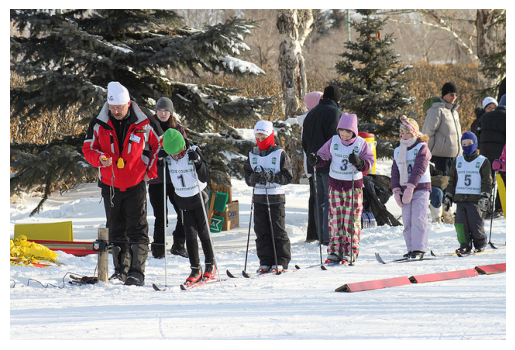

In [ ]:
# sample an image
random_sample_testdata(dataloader_test, encoder, decoder)

[0, 3, 1358, 21, 3, 332, 6, 3, 2223, 1]
a desk with a computer and a monitor


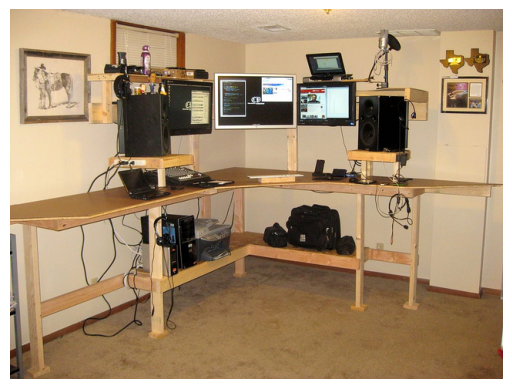

In [ ]:
# sample an image
random_sample_testdata(dataloader_test, encoder, decoder)

[0, 3, 372, 3490, 21, 3, 372, 39, 46, 408, 185, 18, 1]
a clock tower with a clock on it 's side .


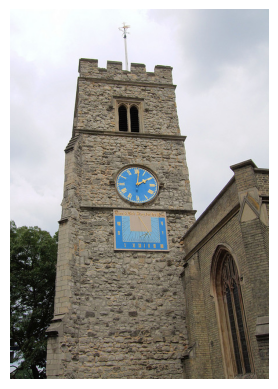

In [ ]:
# sample an image
random_sample_testdata(dataloader_test, encoder, decoder)

## Generating Captions for Custom Image

In [ ]:
def image_captioning_custom_image(img_path, encoder, decoder):
    encoder.eval()
    decoder.eval()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    orig_image = np.array(Image.open(img_path).convert('RGB'))

    plt.imshow(orig_image)
    plt.axis('off')

    # caption prediction
    image_t = transform_eval(Image.open(img_path).convert('RGB'))
    image_t = torch.unsqueeze(image_t, 0)
    image_t = image_t.to(device)
    with torch.no_grad():
        features_t = encoder(image_t).unsqueeze(1)
        token_list = decoder.sample(features_t)
    decoded_word_list, decoded_sentence = get_word_list_and_sentence(token_list)
    print(decoded_sentence)

## Here we take three examples from the output of stable diffusion model and caption these images before generating a SnapScore

#eg1

a bunch of bananas and oranges on a table


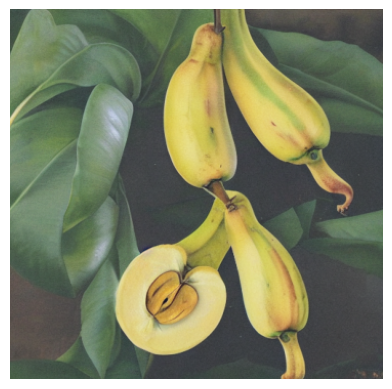

In [ ]:
# Custom images
image_captioning_custom_image("./custom_test_images/banana_apple.png", encoder, decoder)

#BLEU

In [ ]:
import nltk
nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
# Example sentences
reference = "a bunch of bananas and fruits hanging on a tree"
candidate = "a bunch of bananas and oranges on a table"

# Tokenize the sentences
ref_tokens = [word_tokenize(reference)]
cand_tokens = word_tokenize(candidate)

# Smooth BLEU score calculation
smoothie = SmoothingFunction().method4  # Adjust the smoothing function as needed
scoreBLEU = sentence_bleu(ref_tokens, cand_tokens, smoothing_function=smoothie)
print(f"Smoothed BLEU Score: {scoreBLEU:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Smoothed BLEU Score: 0.4594


#Rouge

In [ ]:
!pip install rouge

from rouge import Rouge

# Example sentences
reference = "a bunch of bananas and fruits hanging on a tree"
candidate = "a bunch of bananas and oranges on a table"

# Initialize Rouge
rouge = Rouge()

# Calculate scores
scores = rouge.get_scores(candidate, reference)[0]  # Access the first (and only) set of scores

# Define a smoothing function
def smooth_scores(scores, alpha=0.1):
    for key in scores:
        scores[key]['p'] = (scores[key]['p'] + alpha) / (1 + alpha)
        scores[key]['r'] = (scores[key]['r'] + alpha) / (1 + alpha)
        scores[key]['f'] = (scores[key]['f'] + alpha) / (1 + alpha)
    return scores

# Apply smoothing
smoothed_scores = smooth_scores(scores)

print(smoothed_scores)

average_f1 = (scores['rouge-1']['f'] + scores['rouge-2']['f'] + scores['rouge-l']['f']) / 3
print("Average ROUGE F1 Score:", average_f1)

{'rouge-1': {'r': 0.6969696969696969, 'p': 0.7727272727272726, 'f': 0.7326203163258886}, 'rouge-2': {'r': 0.5959595959595959, 'p': 0.6590909090909091, 'f': 0.6256684446681346}, 'rouge-l': {'r': 0.6969696969696969, 'p': 0.7727272727272726, 'f': 0.7326203163258886}}
Average ROUGE F1 Score: 0.6969696924399708


#meteor

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score

# Example sentences tokenized
reference = "a bunch of bananas and fruits hanging on a tree".split()
hypothesis = "a bunch of bananas and oranges on a table".split()

# Calculate METEOR score
scoreMETEOR = meteor_score([reference], hypothesis)
print("METEOR Score:", scoreMETEOR)


[nltk_data] Downloading package wordnet to /root/nltk_data...


METEOR Score: 0.6988249845392702


#cosine

In [ ]:
!pip install scikit-learn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Example texts
text1 = "a bunch of bananas and fruits hanging on a tree"
text2 = "a bunch of bananas and oranges on a table"

# Initialize a vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the texts
tfidf = vectorizer.fit_transform([text1, text2])

# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]

print("Cosine Similarity:", cosine_sim)


Cosine Similarity: 0.5056055588739691


#SnapScore

It is the weighted average of BLEU, ROUGE, METEOR, cosine

In [ ]:
weights = {
    'BLEU': 0.20,    # Lower weight due to focus on exact n-gram matches
    'ROUGE': 0.20,   # Similar reason as BLEU
    'METEOR': 0.25,  # Higher weight as it accounts for synonyms and structure
    'cosine': 0.35   # Highest weight, focusing on semantic similarity
}

In [ ]:
scores = {
    'BLEU': 0.4594,      # Example BLEU score
    'ROUGE': 0.6969696924399708,    # Example ROUGE score
    'METEOR': 0.6988249845392702,   # Example METEOR score
    'cosine': 0.5056055588739691    # Example cosine similarity score
}


In [ ]:
# Calculate the SNAP Score as a weighted sum of the scores
snap_score = sum(weights[metric] * scores[metric] for metric in weights)

print("SNAP Score:", snap_score)

SNAP Score: 0.5829421302287009


#eg2

a man in a suit and tie standing in front of a television .


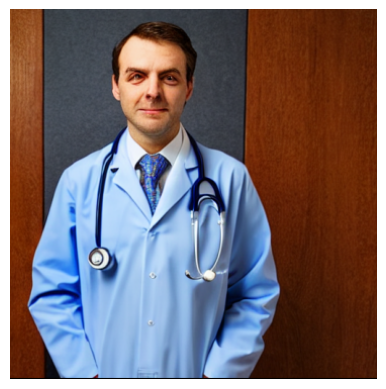

In [ ]:
# example custom image
image_captioning_custom_image("./custom_test_images/doctor.png", encoder, decoder)

#BLEU

In [ ]:
import nltk
nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
# Example sentences
reference = "a man wearing a suit and tie standing with a stethoscope"
candidate = "a man in a suit and tie standing in front of a television "

# Tokenize the sentences
ref_tokens = [word_tokenize(reference)]
cand_tokens = word_tokenize(candidate)

# Smooth BLEU score calculation
smoothie = SmoothingFunction().method4  # Adjust the smoothing function as needed
scoreBLEU = sentence_bleu(ref_tokens, cand_tokens, smoothing_function=smoothie)
print(f"Smoothed BLEU Score: {scoreBLEU:.4f}")

Smoothed BLEU Score: 0.3439


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Rouge

In [ ]:
!pip install rouge

from rouge import Rouge

# Example sentences
reference = "a man wearing a suit and tie standing with a stethoscope"
candidate = "a man in a suit and tie standing in front of a television "

# Initialize Rouge
rouge = Rouge()

# Calculate scores
scores = rouge.get_scores(candidate, reference)[0]  # Access the first (and only) set of scores

# Define a smoothing function
def smooth_scores(scores, alpha=0.1):
    for key in scores:
        scores[key]['p'] = (scores[key]['p'] + alpha) / (1 + alpha)
        scores[key]['r'] = (scores[key]['r'] + alpha) / (1 + alpha)
        scores[key]['f'] = (scores[key]['f'] + alpha) / (1 + alpha)
    return scores

# Apply smoothing
smoothed_scores = smooth_scores(scores)

print(smoothed_scores)

average_f1 = (scores['rouge-1']['f'] + scores['rouge-2']['f'] + scores['rouge-l']['f']) / 3
print("Average ROUGE F1 Score:", average_f1)

{'rouge-1': {'r': 0.6969696969696969, 'p': 0.6363636363636362, 'f': 0.665071765802065}, 'rouge-2': {'r': 0.5454545454545454, 'p': 0.4696969696969697, 'f': 0.5041322268970698}, 'rouge-l': {'r': 0.6969696969696969, 'p': 0.6363636363636362, 'f': 0.665071765802065}}
Average ROUGE F1 Score: 0.6114252528337333


#meteor

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score

# Example sentences tokenized
reference = "a man wearing a suit and tie standing with a stethoscope".split()
hypothesis = "a man in a suit and tie standing in front of a television".split()

# Calculate METEOR score
scoreMETEOR = meteor_score([reference], hypothesis)
print("METEOR Score:", scoreMETEOR)


METEOR Score: 0.6954520089285714


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#cosine

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Example texts
text1 = "a man wearing a suit and tie standing with a stethoscope"
text2 = "a man in a suit and tie standing in front of a television"

# Initialize a vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the texts
tfidf = vectorizer.fit_transform([text1, text2])

# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]

print("Cosine Similarity:", cosine_sim)


Cosine Similarity: 0.3486142726577586


#SnapScore

In [ ]:
weights = {
    'BLEU': 0.20,    # Lower weight due to focus on exact n-gram matches
    'ROUGE': 0.20,   # Similar reason as BLEU
    'METEOR': 0.25,  # Higher weight as it accounts for synonyms and structure
    'cosine': 0.35   # Highest weight, focusing on semantic similarity
}

In [ ]:
scores = {
    'BLEU': 0.3439,      # Example BLEU score
    'ROUGE': 0.6114252528337333,    # Example ROUGE score
    'METEOR': 0.6954520089285714,   # Example METEOR score
    'cosine': 0.3486142726577586    # Example cosine similarity score
}


In [ ]:
# Calculate the SNAP Score as a weighted sum of the scores
snap_score = sum(weights[metric] * scores[metric] for metric in weights)

print("SNAP Score:", snap_score)

SNAP Score: 0.486943048229105


#eg3

a large bear is standing in the grass .


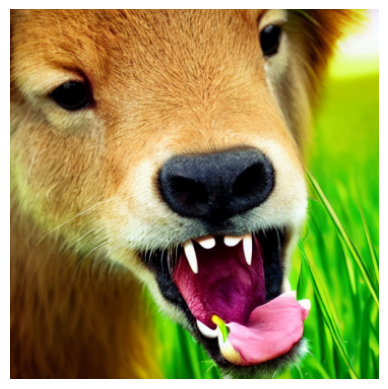

In [ ]:
# example custom image
image_captioning_custom_image("./custom_test_images/animal_grass.png", encoder, decoder)

#BLEU

In [ ]:
import nltk
nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
# Example sentences
reference = "animal standing in the grass with its mouth open"
candidate = "a large bear is standing in the grass ."

# Tokenize the sentences
ref_tokens = [word_tokenize(reference)]
cand_tokens = word_tokenize(candidate)

# Smooth BLEU score calculation
smoothie = SmoothingFunction().method4  # Adjust the smoothing function as needed
scoreBLEU = sentence_bleu(ref_tokens, cand_tokens, smoothing_function=smoothie)
print(f"Smoothed BLEU Score: {scoreBLEU:.4f}")

Smoothed BLEU Score: 0.2985


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Rouge

In [ ]:
!pip install rouge

from rouge import Rouge

# Example sentences
reference = "animal standing in the grass with its mouth open"
candidate = "a large bear is standing in the grass ."

# Initialize Rouge
rouge = Rouge()

# Calculate scores
scores = rouge.get_scores(candidate, reference)[0]  # Access the first (and only) set of scores

# Define a smoothing function
def smooth_scores(scores, alpha=0.1):
    for key in scores:
        scores[key]['p'] = (scores[key]['p'] + alpha) / (1 + alpha)
        scores[key]['r'] = (scores[key]['r'] + alpha) / (1 + alpha)
        scores[key]['f'] = (scores[key]['f'] + alpha) / (1 + alpha)
    return scores

# Apply smoothing
smoothed_scores = smooth_scores(scores)

print(smoothed_scores)

average_f1 = (scores['rouge-1']['f'] + scores['rouge-2']['f'] + scores['rouge-l']['f']) / 3
print("Average ROUGE F1 Score:", average_f1)

{'rouge-1': {'r': 0.49494949494949486, 'p': 0.5454545454545454, 'f': 0.5187165730103805}, 'rouge-2': {'r': 0.43181818181818177, 'p': 0.4805194805194805, 'f': 0.454545450020202}, 'rouge-l': {'r': 0.49494949494949486, 'p': 0.5454545454545454, 'f': 0.5187165730103805}}
Average ROUGE F1 Score: 0.4973261986803211


#METEOR

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score

# Example sentences tokenized
reference = "animal standing in the grass with its mouth open".split()
hypothesis = "a large bear is standing in the grass .".split()

# Calculate METEOR score
scoreMETEOR = meteor_score([reference], hypothesis)
print("METEOR Score:", scoreMETEOR)


METEOR Score: 0.4409722222222222


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#cosine

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Example texts
text1 = "animal standing in the grass with its mouth open"
text2 = "a large bear is standing in the grass ."

# Initialize a vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the texts
tfidf = vectorizer.fit_transform([text1, text2])

# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]

print("Cosine Similarity:", cosine_sim)


Cosine Similarity: 0.3408242166238352


#SnapScore

In [ ]:
weights = {
    'BLEU': 0.20,    # Lower weight due to focus on exact n-gram matches
    'ROUGE': 0.20,   # Similar reason as BLEU
    'METEOR': 0.25,  # Higher weight as it accounts for synonyms and structure
    'cosine': 0.35   # Highest weight, focusing on semantic similarity
}

In [ ]:
scores = {
    'BLEU': 0.2985,      # Example BLEU score
    'ROUGE': 0.4973261986803211,    # Example ROUGE score
    'METEOR': 0.4409722222222222,   # Example METEOR score
    'cosine': 0.3408242166238352    # Example cosine similarity score
}


In [ ]:
# Calculate the SNAP Score as a weighted sum of the scores
snap_score = sum(weights[metric] * scores[metric] for metric in weights)

print("SNAP Score:", snap_score)

SNAP Score: 0.38869677110996215


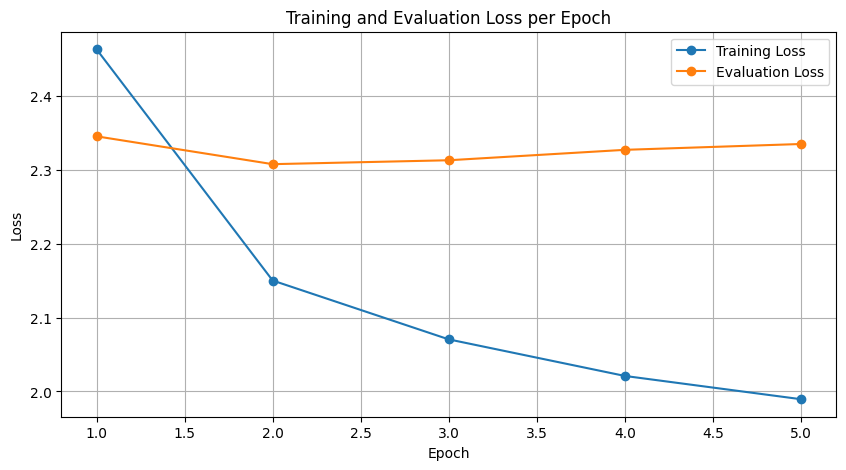

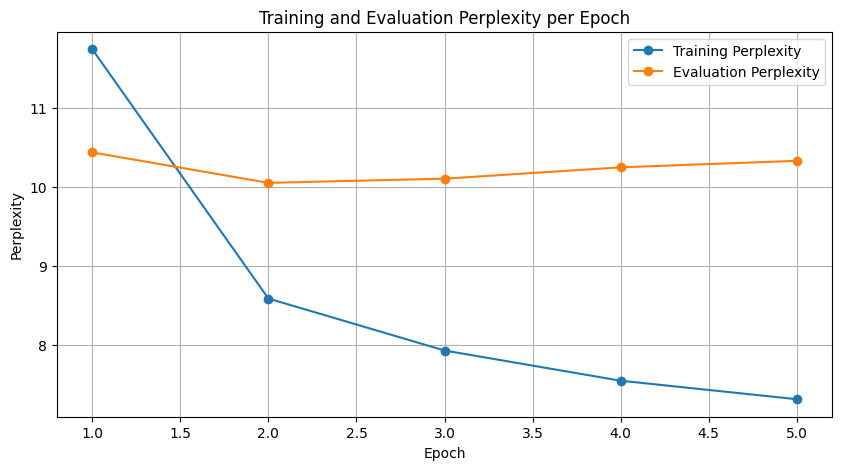

In [ ]:
import matplotlib.pyplot as plt

# Data extracted from the training and evaluation logs as we had tried 5 epochs intially
epochs = [1, 2, 3, 4, 5]
training_loss = [2.4632, 2.1501, 2.0704, 2.0209, 1.9894]
training_perplexity = [11.74213, 8.585793, 7.9278, 7.54556, 7.31110]
evaluation_loss = [2.3453, 2.3076, 2.3129, 2.3270, 2.3349]
evaluation_perplexity = [10.436062, 10.05017, 10.103460, 10.24701, 10.328915]

# Plotting the training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, evaluation_loss, label='Evaluation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and evaluation perplexity
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_perplexity, label='Training Perplexity', marker='o')
plt.plot(epochs, evaluation_perplexity, label='Evaluation Perplexity', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training and Evaluation Perplexity per Epoch')
plt.legend()
plt.grid(True)
plt.show()
